Last updated: June 29th 2016

# Climate data exploration: a journey through Pandas

Welcome to a demo of Python's data analysis package called `Pandas`. Our goal is to learn about Data Analysis and transformation using Pandas while exploring datasets used to analyze climate change. 

## The story

The global goal of this demo is to provide the tools to be able to try and reproduce some of the analysis done in the IPCC global climate reports published in the last decade (see for example https://www.ipcc.ch/pdf/assessment-report/ar5/syr/SYR_AR5_FINAL_full.pdf). 

We are first going to load a few public datasets containing information about global temperature, global and local sea level infomation, and global concentration of greenhouse gases like CO2, to see if there are correlations and how the trends are to evolve, assuming no fundamental change in the system. For all these datasets, we will download them, visualize them, clean them, search through them, merge them, resample them, transform them and summarize them.

In the process, we will learn about:

Part 1:

    1. Loading data
    2. Pandas datastructures
    3. Cleaning and formatting data
    4. Basic visualization
   
Part 2:

    5. Accessing data
    6. Working with dates and times
    7. Transforming datasets
    8. Statistical analysis
    9. Data agregation and summarization
    10. Correlations and regressions
    11. Predictions from auto regression models

## Some initial setup

In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 16)

LARGE_FIGSIZE = (12, 8)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Change this cell to the demo location on YOUR machine
#%cd ~/Projects/pandas_tutorial/climate_timeseries/
%ls

climate_timeseries-Part1.ipynb  data/
climate_timeseries-Part2.ipynb  sandbox/


## 1. Loading data

More details, see http://pandas.pydata.org/pandas-docs/stable/io.html

To find all reading functions in pandas, ask ipython's tab completion:

In [3]:
pd.read_table?


In [12]:
pd.read_table?

### From a local text file

Let's first load some temperature data which covers all lattitudes. Since read_table is supposed to do the job for a text file, let's just try it:

In [6]:
filename = "data/temperatures/annual.land_ocean.90S.90N.df_1901-2000mean.dat"
full_globe_temp = pd.read_table(filename)
full_globe_temp

,1880 -0.1591
0,1881 -0.0789
1,1882 -0.1313
2,1883 -0.1675
3,1884 -0.2485
4,1885 -0.2042
5,1886 -0.1695
6,1887 -0.2505
7,1888 -0.1605
...,...
122,2003 0.5818


There is only 1 column! Let's try again stating that values are separated by any number of spaces:

In [7]:
full_globe_temp = pd.read_table(filename, sep="\s+")
full_globe_temp

,1880,-0.1591
0,1881,-0.0789
1,1882,-0.1313
2,1883,-0.1675
3,1884,-0.2485
4,1885,-0.2042
5,1886,-0.1695
6,1887,-0.2505
7,1888,-0.1605
...,...,...
122,2003,0.5818


There are columns but the column names are 1880 and -0.1591!

In [8]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"])
full_globe_temp

,year,mean temp
0,1880,-0.1591
1,1881,-0.0789
2,1882,-0.1313
3,1883,-0.1675
4,1884,-0.2485
5,1885,-0.2042
6,1886,-0.1695
7,1887,-0.2505
...,...,...
123,2003,0.5818


Since we only have 2 columns, one of which would be nicer to access the data (the year of the record), let's try using the `index_col` option:

In [9]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"], 
                                index_col=0)
full_globe_temp

,mean temp
year,
1880,-0.1591
1881,-0.0789
1882,-0.1313
1883,-0.1675
1884,-0.2485
1885,-0.2042
1886,-0.1695
1887,-0.2505
...,...


Last step: the index is made of dates. Let's make that explicit:

In [11]:
full_globe_temp = pd.read_table(filename, sep="\s+", names=["year", "mean temp"], 
                                index_col=0, parse_dates=True)
full_globe_temp

,mean temp
year,
1880-01-01 00:00:00,-0.1591
1881-01-01 00:00:00,-0.0789
1882-01-01 00:00:00,-0.1313
1883-01-01 00:00:00,-0.1675
1884-01-01 00:00:00,-0.2485
1885-01-01 00:00:00,-0.2042
1886-01-01 00:00:00,-0.1695
1887-01-01 00:00:00,-0.2505
...,...


### From a chunked file

Since every dataset can contain mistakes, let's load a different file with temperature data. NASA's GISS dataset is written in chunks: look at it in `data/temperatures/GLB.Ts+dSST.txt`

In [16]:
giss_temp = pd.read_table("data/temperatures/GLB.Ts+dSST.txt", sep="\s+",skiprows=7,
                          skip_footer=11, engine="python")
giss_temp

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Year.1
0,1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18,1880
1,1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23,1881
2,1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20,1882
3,1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22,1883
4,1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28,1884
5,1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0,-26,-28,-37,-30,-31,-15,1885
6,1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18,-25,-24,-26,-26,-21,-21,1886
7,1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40,-32,-30,-40,-29,-24,-28,1887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2009,56,48,49,57,59,62,66,61,64,58,72,58,59,59,52,55,63,65,2009


**QUIZ:** What happens if you remove the `skiprows`? `skipfooter`? `engine`?

**EXERCISE:** Load some readings of CO2 concentrations in the atmosphere from the `data/greenhouse_gaz/co2_mm_global.txt` data file.

In [18]:
pd.read_table?

In [30]:
Co2_global=pd.read_table("data/greenhouse_gaz/co2_mm_global.txt",parse_dates={'Date':[0,1]},sep='\s+',index_col=0)

### From a remote text file

So far, we have only loaded temperature datasets. Climate change also affects the sea levels on the globe. Let's load some datasets with the sea levels. The university of colorado posts updated timeseries for mean sea level globably, per 
hemisphere, or even per ocean, sea, ... Let's download the global one, and the ones for the northern and southern hemisphere.

That will also illustrate that to load text files that are online, there is no more work than replacing the filepath by a URL n `read_table`:

In [28]:
# Local backup: data/sea_levels/sl_nh.txt
northern_sea_level = pd.read_table("http://sealevel.colorado.edu/files/current/sl_nh.txt", 
                                   sep="\s+")
northern_sea_level

,year,msl_ib(mm),#version_2016_rel3
0,1992.9323,13.717,NaN
1,1992.9595,1.328,NaN
2,1992.9866,-13.375,NaN
3,1993.0138,-24.723,NaN
4,1993.0409,-29.231,NaN
5,1993.0681,-32.538,NaN
6,1993.0952,-35.588,NaN
7,1993.1223,-26.579,NaN
...,...,...,...
853,2016.1440,49.218,NaN


In [29]:
# Local backup: data/sea_levels/sl_sh.txt
southern_sea_level = pd.read_table("http://sealevel.colorado.edu/files/current/sl_sh.txt", 
                                   sep="\s+")
southern_sea_level

,year,msl_ib(mm),#version_2016_rel3
0,1992.9323,2.517,NaN
1,1992.9595,-7.645,NaN
2,1992.9866,-2.267,NaN
3,1993.0138,0.855,NaN
4,1993.0409,-2.020,NaN
5,1993.0681,-0.398,NaN
6,1993.0952,4.102,NaN
7,1993.1223,6.787,NaN
...,...,...,...
853,2016.1440,84.902,NaN


In [31]:
# The 2015 version of the global dataset:
# Local backup: data/sea_levels/sl_ns_global.txt
url = "http://sealevel.colorado.edu/files/2015_rel2/sl_ns_global.txt"
global_sea_level = pd.read_table(url, sep="\s+")
global_sea_level

,year,msl_ib_ns(mm),#version_2015_rel2
0,1992.9595,-5.818,NaN
1,1992.9866,-7.525,NaN
2,1993.0138,-9.215,NaN
3,1993.0409,-11.796,NaN
4,1993.0681,-11.291,NaN
5,1993.0952,-9.569,NaN
6,1993.1223,-3.714,NaN
7,1993.1495,-2.471,NaN
...,...,...,...
772,2014.9494,70.723,NaN


There are clearly lots of cleanup to be done on these datasets. See below...

### From a local or remote HTML file

To be able to grab more local data about mean sea levels, we can download and extract data about mean sea level stations around the world from the PSMSL (http://www.psmsl.org/). Again to download and parse all tables in a webpage, just give `read_html` the URL to parse:

In [32]:
# Needs `lxml`, `beautifulSoup4` and `html5lib` python packages
# Local backup in data/sea_levels/Obtaining Tide Gauge Data.html
table_list = pd.read_html("http://www.psmsl.org/data/obtaining/")

In [33]:
# there is 1 table on that page which contains metadata about the stations where 
# sea levels are recorded
local_sea_level_stations = table_list[0]
local_sea_level_stations

,Station Name,ID,Lat.,Lon.,GLOSS ID,Country,Date,Coastline,Station
0,HELIGMAN,231,60.200,19.300,NaN,ALA,01/01/1980,60,251
1,KOBBAKLINTAR,63,60.033,19.883,NaN,ALA,01/01/1980,60,261
2,LEMSTROM,84,60.100,20.017,NaN,ALA,01/01/1980,60,271
3,FOGLO / DEGERBY,249,60.032,20.385,NaN,ALA,06/10/2015,60,281
4,PAGO PAGO,539,-14.280,-170.690,144.0,ASM,08/03/2016,745,1
5,BAHIA ESPERANZA,988,-63.300,-56.917,185.0,ATA,11/05/1999,999,1
6,ARGENTINE ISLANDS,913,-65.246,-64.257,188.0,ATA,21/05/2015,999,3
7,PUERTO SOBERANIA,1603,-62.483,-59.633,189.0,ATA,30/09/2004,999,5
...,...,...,...,...,...,...,...,...,...
1459,DANANG,1475,16.100,108.217,NaN,VNM,17/11/2015,605,51


That table can be used to search for a station in a region of the world we choose, extract an ID for it and download the corresponding time series with the URL http://www.psmsl.org/data/obtaining/met.monthly.data/< ID >.metdata

## 2. Pandas DataStructures

For more details, see http://pandas.pydata.org/pandas-docs/stable/dsintro.html

Now that we have used `read_**` functions to load datasets, we need to understand better what kind of objects we got from them to learn to work with them.

### DataFrame, the pandas 2D structure

In [34]:
# Type of the object?
type(giss_temp)

pandas.core.frame.DataFrame

In [35]:
# Internal nature of the object
print(giss_temp.shape)
print(giss_temp.dtypes)

(143, 20)
Year      object
Jan       object
Feb       object
Mar       object
Apr       object
May       object
Jun       object
Jul       object
           ...  
Dec       object
J-D       object
D-N       object
DJF       object
MAM       object
JJA       object
SON       object
Year.1    object
dtype: object


Descriptors for the vertical axis (axis=0)

In [36]:
giss_temp.index

RangeIndex(start=0, stop=143, step=1)

Descriptors for the horizontal axis (axis=1)

In [37]:
giss_temp.columns

Index([u'Year', u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', u'Aug',
       u'Sep', u'Oct', u'Nov', u'Dec', u'J-D', u'D-N', u'DJF', u'MAM', u'JJA',
       u'SON', u'Year.1'],
      dtype='object')

A lot of information at once including memory usage:

In [38]:
giss_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 20 columns):
Year      143 non-null object
Jan       143 non-null object
Feb       143 non-null object
Mar       143 non-null object
Apr       143 non-null object
May       143 non-null object
Jun       143 non-null object
Jul       143 non-null object
Aug       143 non-null object
Sep       143 non-null object
Oct       143 non-null object
Nov       143 non-null object
Dec       143 non-null object
J-D       143 non-null object
D-N       143 non-null object
DJF       143 non-null object
MAM       143 non-null object
JJA       143 non-null object
SON       143 non-null object
Year.1    143 non-null object
dtypes: object(20)
memory usage: 22.4+ KB


### Series, the pandas 1D structure

A series can be constructed with the `pd.Series` constructor (passing a list or array of values) or from a `DataFrame`, by extracting one of its columns.

In [39]:
# Do we already have a series for the full_globe_temp?
type(full_globe_temp)

pandas.core.frame.DataFrame

In [40]:
# Since there is only one column of values, we can make this a Series without 
# loosing information:
full_globe_temp = full_globe_temp["mean temp"]

Core attributes/information:

In [41]:
print(type(full_globe_temp))
print(full_globe_temp.dtype)
print(full_globe_temp.shape)
print(full_globe_temp.nbytes)

<class 'pandas.core.series.Series'>
float64
(131,)
1048


Probably the most important attribute of a `Series` or `DataFrame` is its `index` since we will use that to, well, index into the structures to access te information:

In [42]:
full_globe_temp.index

DatetimeIndex(['1880-01-01', '1881-01-01', '1882-01-01', '1883-01-01',
               '1884-01-01', '1885-01-01', '1886-01-01', '1887-01-01',
               '1888-01-01', '1889-01-01',
               ...
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01'],
              dtype='datetime64[ns]', name=u'year', length=131, freq=None)

### NumPy arrays as backend of Pandas

It is always possible to fall back to a good old NumPy array to pass on to scientific libraries that need them: SciPy, scikit-learn, ...

In [43]:
full_globe_temp.values

array([ -1.59100000e-01,  -7.89000000e-02,  -1.31300000e-01,
        -1.67500000e-01,  -2.48500000e-01,  -2.04200000e-01,
        -1.69500000e-01,  -2.50500000e-01,  -1.60500000e-01,
        -1.10300000e-01,  -3.01400000e-01,  -2.52700000e-01,
        -2.92600000e-01,  -3.27400000e-01,  -2.88000000e-01,
        -2.14600000e-01,  -1.00900000e-01,  -1.29400000e-01,
        -2.51700000e-01,  -1.35600000e-01,  -1.12500000e-01,
        -1.69300000e-01,  -2.25500000e-01,  -3.44200000e-01,
        -3.79900000e-01,  -2.58300000e-01,  -2.06000000e-01,
        -3.72600000e-01,  -3.92200000e-01,  -4.04100000e-01,
        -3.86000000e-01,  -4.14400000e-01,  -3.42200000e-01,
        -3.19600000e-01,  -1.59900000e-01,  -8.10000000e-02,
        -2.80300000e-01,  -3.22700000e-01,  -2.10600000e-01,
        -2.18600000e-01,  -2.02500000e-01,  -1.39000000e-01,
        -2.22200000e-01,  -2.06300000e-01,  -1.84300000e-01,
        -1.26000000e-01,  -1.92000000e-02,  -1.00700000e-01,
        -9.35000000e-02,

In [44]:
type(full_globe_temp.values)

numpy.ndarray

In [45]:
full_globe_temp.values.shape

(131,)

### Creating new DataFrames manually

`DataFrame`s can also be created manually, by grouping several Series together. Let's make a new frame from the 3 sea level datasets we downloaded above. They will be displayed along the same index. Wait, does that makes sense to do that?

In [50]:
southern_sea_level.columns

Index([u'year', u'msl_ib(mm)', u'#version_2016_rel3'], dtype='object')

In [46]:
# Are they aligned?
southern_sea_level.year == northern_sea_level.year

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
       ... 
853    True
854    True
855    True
856    True
857    True
858    True
859    True
860    True
Name: year, dtype: bool

In [51]:
# So, are they aligned?
np.all(southern_sea_level.year == northern_sea_level.year)

True

So the northern hemisphere and southern hemisphere datasets are aligned. What about the global one?

In [52]:
len(global_sea_level.year) == len(northern_sea_level.year)

False

For now, let's just build a DataFrame with the 2 hemisphere datasets then. We will come back to add the global one later...

In [53]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"], 
                               "southern_hem": southern_sea_level["msl_ib(mm)"], 
                               "date": northern_sea_level.year})
mean_sea_level

,date,northern_hem,southern_hem
0,1992.9323,13.717,2.517
1,1992.9595,1.328,-7.645
2,1992.9866,-13.375,-2.267
3,1993.0138,-24.723,0.855
4,1993.0409,-29.231,-2.020
5,1993.0681,-32.538,-0.398
6,1993.0952,-35.588,4.102
7,1993.1223,-26.579,6.787
...,...,...,...
853,2016.1440,49.218,84.902


Note: there are other ways to create DataFrames manually, for example from a 2D numpy array.

There is still the date in a regular column and a numerical index that is not that meaningful. We can specify the `index` of a `DataFrame` at creation. Let's try:

In [54]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"], 
                               "southern_hem": southern_sea_level["msl_ib(mm)"]},
                               index = northern_sea_level.year)
mean_sea_level

,northern_hem,southern_hem
year,,
1992.9323,NaN,NaN
1992.9595,NaN,NaN
1992.9866,NaN,NaN
1993.0138,NaN,NaN
1993.0409,NaN,NaN
1993.0681,NaN,NaN
1993.0952,NaN,NaN
1993.1223,NaN,NaN
...,...,...


In [56]:
mean_sea_level.columns

Index([u'northern_hem', u'southern_hem'], dtype='object')

Now the fact that it is failing show that Pandas does auto-alignment of values: for each value of the index, it searches for a value in each Series that maps the same value. Since these series have a dumb numerical index, no values are found. 

Since we know that the order of the values match the index we chose, we can replace the Series by their values only at creation of the DataFrame:

In [57]:
mean_sea_level = pd.DataFrame({"northern_hem": northern_sea_level["msl_ib(mm)"].values, 
                               "southern_hem": southern_sea_level["msl_ib(mm)"].values},
                               index = northern_sea_level.year)
mean_sea_level

,northern_hem,southern_hem
year,,
1992.9323,13.717,2.517
1992.9595,1.328,-7.645
1992.9866,-13.375,-2.267
1993.0138,-24.723,0.855
1993.0409,-29.231,-2.020
1993.0681,-32.538,-0.398
1993.0952,-35.588,4.102
1993.1223,-26.579,6.787
...,...,...


## 3. Cleaning and formatting data

The datasets that we obtain straight from the reading functions are pretty raw. A lot of pre-processing can be done during data read but we haven't used all the power of the reading functions. Let's learn to do a lot of cleaning and formatting of the data.

The GISS temperature dataset has a lot of issues too: useless numerical index, redundant columns, useless rows, placeholder (`****`) for missing values, and wrong type for the columns. Let's fix all this:

### Renaming columns

In [58]:
# The columns of the local_sea_level_stations aren't clean: they contain spaces and dots.
local_sea_level_stations.columns

Index([u'Station Name', u'ID', u'Lat.', u'Lon.', u'GLOSS ID  ', u'Country  ',
       u'Date', u'Coastline  ', u'Station  '],
      dtype='object')

In [59]:
# Let's clean them up a bit:
local_sea_level_stations.columns = [name.strip().replace(".", "") 
                                    for name in local_sea_level_stations.columns]
local_sea_level_stations.columns

Index([u'Station Name', u'ID', u'Lat', u'Lon', u'GLOSS ID', u'Country',
       u'Date', u'Coastline', u'Station'],
      dtype='object')

We can also rename an index by setting its name. For example, the index of the `mean_sea_level` dataFrame could be called `date` since it contains more than just the year:

In [60]:
mean_sea_level.index.name = "date"
mean_sea_level

,northern_hem,southern_hem
date,,
1992.9323,13.717,2.517
1992.9595,1.328,-7.645
1992.9866,-13.375,-2.267
1993.0138,-24.723,0.855
1993.0409,-29.231,-2.020
1993.0681,-32.538,-0.398
1993.0952,-35.588,4.102
1993.1223,-26.579,6.787
...,...,...


### Setting missing values

In the full globe dataset, -999.00 was used to indicate that there was no value for that year. Let's search for all these values and replace them with the missing value that Pandas understand: `np.nan` 

In [61]:
full_globe_temp == -999.000

year
1880-01-01 00:00:00    False
1881-01-01 00:00:00    False
1882-01-01 00:00:00    False
1883-01-01 00:00:00    False
1884-01-01 00:00:00    False
1885-01-01 00:00:00    False
1886-01-01 00:00:00    False
1887-01-01 00:00:00    False
                       ...  
2003-01-01             False
2004-01-01             False
2005-01-01             False
2006-01-01             False
2007-01-01             False
2008-01-01             False
2009-01-01             False
2010-01-01              True
Name: mean temp, dtype: bool

In [62]:
full_globe_temp[full_globe_temp == -999.000] = np.nan
full_globe_temp.tail()

year
2006-01-01    0.5601
2007-01-01    0.5472
2008-01-01    0.4804
2009-01-01    0.5551
2010-01-01       NaN
Name: mean temp, dtype: float64

In [67]:
full_globe_temp2 = pd.read_table(filename, sep="\s+", names=["year", "mean temp"], na_values=-999.000,
                                index_col=0, parse_dates=True,)
full_globe_temp2=full_globe_temp2['mean temp']
full_globe_temp2.tail()

year
2006-01-01    0.5601
2007-01-01    0.5472
2008-01-01    0.4804
2009-01-01    0.5551
2010-01-01       NaN
Name: mean temp, dtype: float64

### Choosing what is the index

In [68]:
# We didn't set a column number of the index of giss_temp, we can do that afterwards:
giss_temp = giss_temp.set_index("Year")
giss_temp.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Year.1
Year,,,,,,,,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18,1880
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23,1881
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20,1882
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22,1883
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28,1884


### Dropping rows and columns

In [69]:
# 1 column is redundant with the index: 
giss_temp.columns

Index([u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', u'Aug', u'Sep',
       u'Oct', u'Nov', u'Dec', u'J-D', u'D-N', u'DJF', u'MAM', u'JJA', u'SON',
       u'Year.1'],
      dtype='object')

In [70]:
# Let's drop it:
giss_temp = giss_temp.drop("Year.1", axis=1)
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21,-22,***,****,-23,-18,-18
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18,-14,-14,-17,-3,-15,-23
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37,-17,-16,-4,-15,-23,-20
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21,-20,-21,-38,-18,-8,-22
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25,-28,-28,-18,-33,-31,-28
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0,-26,-28,-37,-30,-31,-15
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18,-25,-24,-26,-26,-21,-21
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40,-32,-30,-40,-29,-24,-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [71]:
# We can also just select the columns we want to keep:
giss_temp = giss_temp[[u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', 
                       u'Aug', u'Sep', u'Oct', u'Nov', u'Dec']]
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40
...,...,...,...,...,...,...,...,...,...,...,...,...


In [72]:
# Let's remove all these extra column names (Year  Jan ...). They all correspond to the index "Year"
giss_temp = giss_temp.drop("Year")
giss_temp

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-34,-27,-22,-30,-16,-24,-19,-12,-20,-19,-16,-21
1881,-13,-16,-2,-3,-3,-27,-12,-8,-18,-23,-28,-18
1882,3,4,-2,-24,-20,-32,-27,-11,-11,-25,-25,-37
1883,-38,-38,-12,-20,-20,-8,-3,-13,-19,-19,-28,-21
1884,-20,-14,-31,-36,-33,-36,-31,-24,-29,-25,-29,-25
1885,-57,-29,-19,-36,-35,-40,-28,-24,-17,-14,-14,0
1886,-37,-43,-34,-23,-21,-30,-13,-21,-12,-22,-29,-18
1887,-60,-43,-26,-34,-28,-25,-19,-28,-24,-33,-29,-40
...,...,...,...,...,...,...,...,...,...,...,...,...


Let's also set `****` to a real missing value (`np.nan`). We can often do it using a boolean mask, but that may trigger pandas warning. Another way to assign based on a boolean condition is to use the `where` method:

In [73]:
#giss_temp[giss_temp == "****"] = np.nan
giss_temp = giss_temp.where(giss_temp != "****", np.nan)

In [74]:
giss_temp.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45,44,57,60,47,54,70,69,52,60,50,48
2012,38,43,52,62,71,59,50,56,68,73,69,46
2013,62,52,60,48,56,61,53,61,73,61,75,61
2014,68,44,71,72,79,62,50,74,81,78,64,74
2015,75,80,84,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding columns

While building the `mean_sea_level` dataFrame earlier, we didn't include the values from `global_sea_level` since the years were not aligned. Adding a column to a dataframe is as easy as adding an entry to a dictionary. So let's try:

In [75]:
mean_sea_level["mean_global"] = global_sea_level["msl_ib_ns(mm)"]
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.717,2.517,NaN
1992.9595,1.328,-7.645,NaN
1992.9866,-13.375,-2.267,NaN
1993.0138,-24.723,0.855,NaN
1993.0409,-29.231,-2.020,NaN
1993.0681,-32.538,-0.398,NaN
1993.0952,-35.588,4.102,NaN
1993.1223,-26.579,6.787,NaN
...,...,...,...


The column is full of NaNs again because the auto-alignment feature of Pandas is searching for the index values like `1992.9323` in the index of `global_sea_level["msl_ib_ns(mm)"]` series and not finding them. Let's set its index to these years so that that auto-alignment can work for us and figure out which values we have and not:

In [76]:
global_sea_level = global_sea_level.set_index("year")
global_sea_level["msl_ib_ns(mm)"]

year
1992.9595    -5.818
1992.9866    -7.525
1993.0138    -9.215
1993.0409   -11.796
1993.0681   -11.291
1993.0952    -9.569
1993.1223    -3.714
1993.1495    -2.471
              ...  
2014.9494    70.723
2014.9766    70.522
2015.0037    66.662
2015.0309    64.804
2015.0580    62.115
2015.0852    68.589
2015.1123    69.745
2015.1395    75.007
Name: msl_ib_ns(mm), dtype: float64

In [77]:
mean_sea_level["mean_global"] = global_sea_level["msl_ib_ns(mm)"]
mean_sea_level

,northern_hem,southern_hem,mean_global
date,,,
1992.9323,13.717,2.517,NaN
1992.9595,1.328,-7.645,-5.818
1992.9866,-13.375,-2.267,-7.525
1993.0138,-24.723,0.855,-9.215
1993.0409,-29.231,-2.020,-11.796
1993.0681,-32.538,-0.398,-11.291
1993.0952,-35.588,4.102,-9.569
1993.1223,-26.579,6.787,-3.714
...,...,...,...


**EXERCISE:** Create a new series containing the average of the 2 hemispheres minus the global value to see if that is close to 0. Work inside the mean_sea_level dataframe first. Then try with the original Series to see what happens with data alignment while doing computations.

In [87]:
new_Series=((mean_sea_level["northern_hem"]+mean_sea_level["southern_hem"])/2)-mean_sea_level["mean_global"]

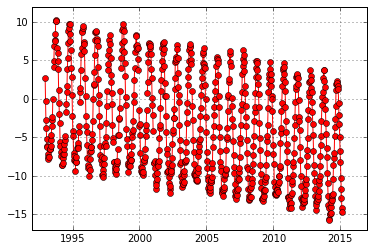

In [91]:
plt.plot(new_Series.index,new_Series.values,'ro-')
plt.xlim([1992,2017])
plt.ylim([-17,12])
plt.grid()

### Changing dtype of series

Now that the sea levels are looking pretty good, let's got back to the GISS temperature dataset. Because of the labels (strings) found in the middle of the timeseries, every column only assumed to contain strings (didn't convert them to floating point values):

In [92]:
giss_temp.dtypes

Jan    object
Feb    object
Mar    object
Apr    object
May    object
Jun    object
Jul    object
Aug    object
Sep    object
Oct    object
Nov    object
Dec    object
dtype: object

That can be changed after the fact (and after the cleanup) with the `astype` method of a `Series`:

In [93]:
giss_temp["Jan"].astype("float32")

Year
1880   -34.0
1881   -13.0
1882     3.0
1883   -38.0
1884   -20.0
1885   -57.0
1886   -37.0
1887   -60.0
        ... 
2008    22.0
2009    56.0
2010    66.0
2011    45.0
2012    38.0
2013    62.0
2014    68.0
2015    75.0
Name: Jan, dtype: float32

In [94]:
for col in giss_temp.columns:
    giss_temp.loc[:, col] = giss_temp[col].astype(np.float32)

An index has a `dtype` just like any Series and that can be changed after the fact too.

In [95]:
giss_temp.index.dtype

dtype('O')

For now, let's change it to an integer so that values can at least be compared properly. We will learn below to change it to a datetime object.

In [96]:
giss_temp.index = giss_temp.index.astype(np.int32)

### Removing missing values

Removing missing values - once they have been converted to `np.nan` - is very easy. Entries that contain missing values can be removed (dropped), or filled with many strategies.

In [97]:
full_globe_temp

year
1880-01-01 00:00:00   -0.1591
1881-01-01 00:00:00   -0.0789
1882-01-01 00:00:00   -0.1313
1883-01-01 00:00:00   -0.1675
1884-01-01 00:00:00   -0.2485
1885-01-01 00:00:00   -0.2042
1886-01-01 00:00:00   -0.1695
1887-01-01 00:00:00   -0.2505
                        ...  
2003-01-01             0.5818
2004-01-01             0.5416
2005-01-01             0.6154
2006-01-01             0.5601
2007-01-01             0.5472
2008-01-01             0.4804
2009-01-01             0.5551
2010-01-01                NaN
Name: mean temp, dtype: float64

In [98]:
full_globe_temp.dropna()

year
1880-01-01 00:00:00   -0.1591
1881-01-01 00:00:00   -0.0789
1882-01-01 00:00:00   -0.1313
1883-01-01 00:00:00   -0.1675
1884-01-01 00:00:00   -0.2485
1885-01-01 00:00:00   -0.2042
1886-01-01 00:00:00   -0.1695
1887-01-01 00:00:00   -0.2505
                        ...  
2002-01-01             0.5745
2003-01-01             0.5818
2004-01-01             0.5416
2005-01-01             0.6154
2006-01-01             0.5601
2007-01-01             0.5472
2008-01-01             0.4804
2009-01-01             0.5551
Name: mean temp, dtype: float64

In [99]:
# This will remove any year that has a missing value. Use how='all' to keep partial years
giss_temp.dropna(how="any").tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,66.0,75.0,87.0,82.0,71.0,60.0,56.0,59.0,55.0,65.0,74.0,44.0
2011,45.0,44.0,57.0,60.0,47.0,54.0,70.0,69.0,52.0,60.0,50.0,48.0
2012,38.0,43.0,52.0,62.0,71.0,59.0,50.0,56.0,68.0,73.0,69.0,46.0
2013,62.0,52.0,60.0,48.0,56.0,61.0,53.0,61.0,73.0,61.0,75.0,61.0
2014,68.0,44.0,71.0,72.0,79.0,62.0,50.0,74.0,81.0,78.0,64.0,74.0


In [100]:
giss_temp.fillna(value=0).tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45.0,44.0,57.0,60.0,47.0,54.0,70.0,69.0,52.0,60.0,50.0,48.0
2012,38.0,43.0,52.0,62.0,71.0,59.0,50.0,56.0,68.0,73.0,69.0,46.0
2013,62.0,52.0,60.0,48.0,56.0,61.0,53.0,61.0,73.0,61.0,75.0,61.0
2014,68.0,44.0,71.0,72.0,79.0,62.0,50.0,74.0,81.0,78.0,64.0,74.0
2015,75.0,80.0,84.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# This fills them with the previous year. See also temp3.interpolate
giss_temp.fillna(method="ffill").tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,45.0,44.0,57.0,60.0,47.0,54.0,70.0,69.0,52.0,60.0,50.0,48.0
2012,38.0,43.0,52.0,62.0,71.0,59.0,50.0,56.0,68.0,73.0,69.0,46.0
2013,62.0,52.0,60.0,48.0,56.0,61.0,53.0,61.0,73.0,61.0,75.0,61.0
2014,68.0,44.0,71.0,72.0,79.0,62.0,50.0,74.0,81.0,78.0,64.0,74.0
2015,75.0,80.0,84.0,71.0,79.0,62.0,50.0,74.0,81.0,78.0,64.0,74.0


Let's also mention the `.interpolate` method on a `Series`:

In [102]:
giss_temp.Aug.interpolate().tail()

Year
2011    69.0
2012    56.0
2013    61.0
2014    74.0
2015    74.0
Name: Aug, dtype: float32

For now, we will leave the missing values in all our datasets, because it wouldn't be meaningful to fill them.

**EXERCISE:** Go back to the reading functions, and learn more about other options that could have allowed us to fold some of these pre-processing steps into the data loading.

## 4. Basic visualization

Now they have been formatted, visualizing your datasets is the next logical step and is trivial with Pandas. The first thing to try is to invoke the `.plot` to generate a basic visualization (uses matplotlib under the covers).

### Line plots

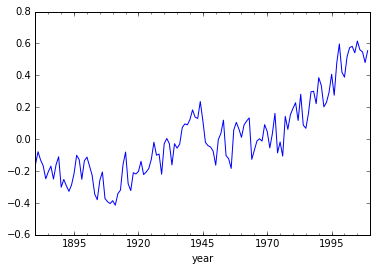

In [103]:
full_globe_temp.plot()

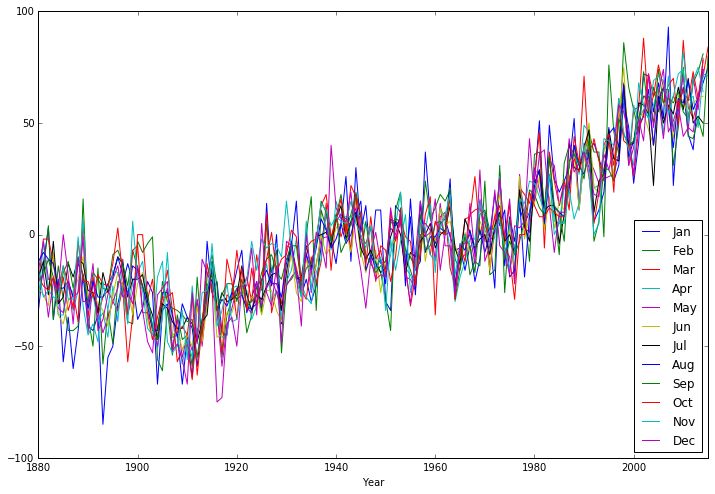

In [104]:
giss_temp.plot(figsize=LARGE_FIGSIZE)

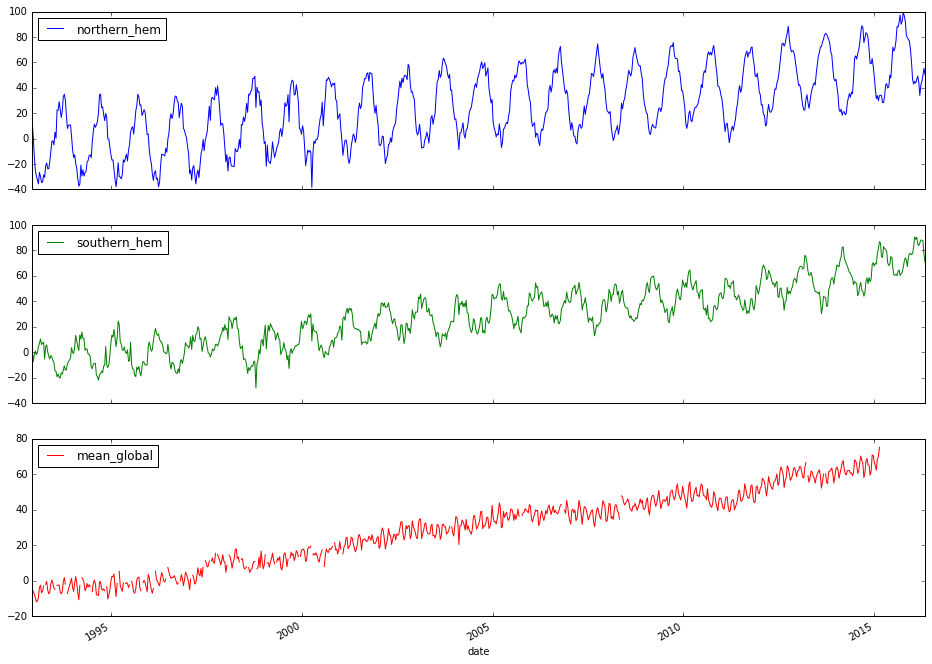

In [105]:
mean_sea_level.plot(subplots=True, figsize=(16, 12));

### Showing distributions information

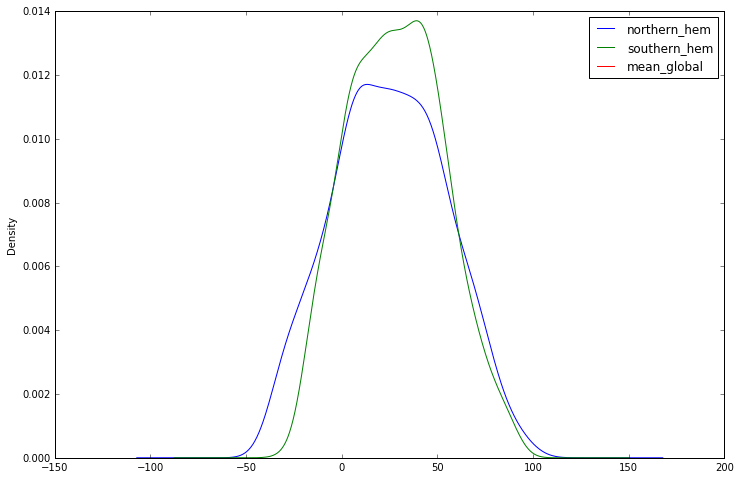

In [106]:
# Distributions of mean sean level globally and per hemisphere?
mean_sea_level.plot(kind="kde", figsize=(12, 8))

**QUIZ:** How to list the possible kinds of plots that the plot method can allow?

In [119]:
mean_sea_level.plot?

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


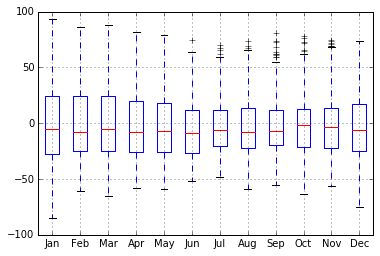

In [120]:
# Distributions of temperature in each month since 1880
giss_temp.boxplot();

### Correlations

There are more plot options inside `pandas.tools.plotting`:

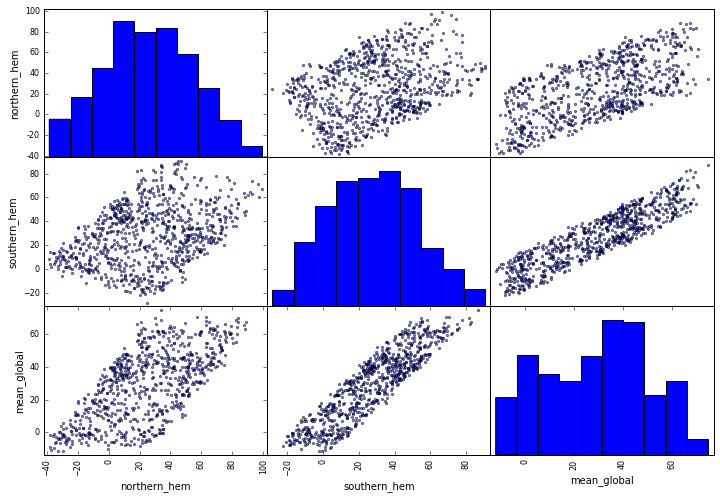

In [117]:
# Is there correlations between the northern and southern sea level timeseries we loaded?
from pandas.tools.plotting import scatter_matrix
scatter_matrix(mean_sea_level, figsize=LARGE_FIGSIZE);

We will confirm the correlations we think we see further down...

## 5. Storing our work

For each `read_**` function to load data, there is a `to_**` method attached to Series and DataFrames.

**EXERCISE**: explore how the to_csv method work using `ipython`'s ? and store the `giss_temp` dataframe. Do the same to store the full_globe_temp series to another file.

In [124]:
giss_temp.to_csv("Giss_sav.csv",sep='\t')

Another file format that is commonly used is Excel, and there multiple datasets can be stored in 1 file.

In [126]:
writer = pd.ExcelWriter("test.xls")

In [128]:
giss_temp.to_excel(writer, sheet_name="GISS temp data")


Exception: Attempt to overwrite cell: sheetname=u'GISS temp data' rowx=0 colx=1

In [129]:
writer.close()

In [130]:
with pd.ExcelWriter("test.xls") as writer:
    giss_temp.to_excel(writer, sheet_name="GISS temp data")
    pd.DataFrame({"Full Globe Temp": full_globe_temp}).to_excel(writer, sheet_name="FullGlobe temp data")

In [131]:
%ls

Giss_sav.csv                    data/
climate_timeseries-Part1.ipynb  sandbox/
climate_timeseries-Part2.ipynb  test.xls


Another, more powerful file format to store binary data, which allows us to store both `Series` and `DataFrame`s without having to cast anybody is HDF5.

In [141]:
with pd.HDFStore("all_data.h5") as writer:
    giss_temp.to_hdf(writer, "/temperatures/giss")
    full_globe_temp.to_hdf(writer, "/temperatures/full_globe")
    mean_sea_level.to_hdf(writer, "/sea_level/mean_sea_level")
    local_sea_level_stations.to_hdf(writer, "/sea_level/stations")
    print writer

<class 'pandas.io.pytables.HDFStore'>
File path: all_data.h5
/sea_level/mean_sea_level            frame        (shape->[861,3]) 
/sea_level/stations                  frame        (shape->[1467,3])
/temperatures/full_globe             series       (shape->[131])   
/temperatures/giss                   frame        (shape->[136,12])


In [143]:
wrap=pd.read_hdf("all_data.h5","/temperatures/giss")
pd.HDFStore("all_data.h5")

<class 'pandas.io.pytables.HDFStore'>
File path: all_data.h5
/sea_level/mean_sea_level            frame        (shape->[861,3]) 
/sea_level/stations                  frame        (shape->[1467,3])
/temperatures/full_globe             series       (shape->[131])   
/temperatures/giss                   frame        (shape->[136,12])

**EXERCISE**: Add the greenhouse gas dataset in this data store. Store it in a separate folder.